**Time-Series Analysis**
=========

(1) Import Modules and Setup Environment
-----

In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.signal as sig

(1) Setup Directory Paths
----

In [22]:
pwd = os.getcwd()

FRF = '2' # if 1D, FRF = '1' & if 2D, FRF = '2'


assert FRF in ['1','2'],"Use FRF = '1' if 1D or FRF = '2' if 2D!"  
if FRF == '1':
    projectDir = os.path.join(pwd,'FRF1D')
else:
    projectDir = os.path.join(pwd,'FRF2D')
    
simDir = os.path.join(projectDir,'FRF2D_2015100623-Oct1stSurvey-2974979')
outputDir = os.path.join(simDir,'output')

plotDir = os.path.join(simDir,'plots')
try:
    # Create target Directory
    os.mkdir(plotDir)
    print("Directory " , plotDir ,  " Created ") 
except FileExistsError:
    print("Directory " , plotDir ,  " already exists")

prefix = 'sta_'
filePrefix = os.path.join(outputDir, prefix)


Directory  /Users/rdchlgs8/Desktop/FRF/post-process/FRF2D/FRF2D_2015100623-Oct1stSurvey-2974979/plots  Created 


(2) Station/Gauges Setup
-----
Need to set the appropraite number of stations you recorded in output directory `numOfStations`.

**NOTE:** in the newer/future versions of FUNWAVE we will standardize the numbering of output files with five digits. Here you use four for stations `{:0>4d}` ... as those changes roll in you will need to change `4` to `5`. 

In [23]:
# Four stations for in this example
numOfStations = 6

stationList = []

for station in range(numOfStations):
    fileName = filePrefix+'{:0>4d}'.format(station+1)
    print("Reading in: "+fileName)
    timeSeries = np.loadtxt(fileName)
    stationList.append(timeSeries)

Reading in: /Users/rdchlgs8/Desktop/FRF/post-process/FRF2D/FRF2D_2015100623-Oct1stSurvey-2974979/output/sta_0001
Reading in: /Users/rdchlgs8/Desktop/FRF/post-process/FRF2D/FRF2D_2015100623-Oct1stSurvey-2974979/output/sta_0002
Reading in: /Users/rdchlgs8/Desktop/FRF/post-process/FRF2D/FRF2D_2015100623-Oct1stSurvey-2974979/output/sta_0003
Reading in: /Users/rdchlgs8/Desktop/FRF/post-process/FRF2D/FRF2D_2015100623-Oct1stSurvey-2974979/output/sta_0004
Reading in: /Users/rdchlgs8/Desktop/FRF/post-process/FRF2D/FRF2D_2015100623-Oct1stSurvey-2974979/output/sta_0005
Reading in: /Users/rdchlgs8/Desktop/FRF/post-process/FRF2D/FRF2D_2015100623-Oct1stSurvey-2974979/output/sta_0006


In [24]:
# calclate Hsig and/or Hrms
def calculateHsig(f,Spec_density, stationIndex):
    
    dfreq=f[1]-f[0]

    totalE=np.sum(Spec_density*dfreq)
    
    Hrms=np.sqrt(totalE*8)
    Hmo = np.sqrt(2.0) * Hrms
    
    print('Station # ',stationIndex+1, ' =>  Hmo = ', Hmo)
    return(Hmo)

(3) Time Series Analysis (Spectral) Using PWELCH Transform
-------
General notes:
   * Window size here is 250 instances
   * **`sta_000#`** contains 4 columns (first is time stamp, second is surface elvation, third and forth are U and V horizontal velocities)
   * **`dt`** is your time step of station recording (in `FUNWAVE` it is `PLOT_INTV_STATION`)
   * the smaller you make the windowing (`nOverlap and nFFT`) the smoother the spectra will look, recommend to use power of 2 for sizes and generally `nOverlap` half the size of `nFFT`.

Index:  0 ...  Station #:  1
Station #  1  =>  Hmo =  2.0107170407031587
Index:  1 ...  Station #:  2
Station #  2  =>  Hmo =  2.137890191759715
Index:  2 ...  Station #:  3
Station #  3  =>  Hmo =  1.927886166593289
Index:  3 ...  Station #:  4
Station #  4  =>  Hmo =  1.6019650553570959
Index:  4 ...  Station #:  5
Station #  5  =>  Hmo =  1.4851049712784348
Index:  5 ...  Station #:  6
Station #  6  =>  Hmo =  1.3886014173561958


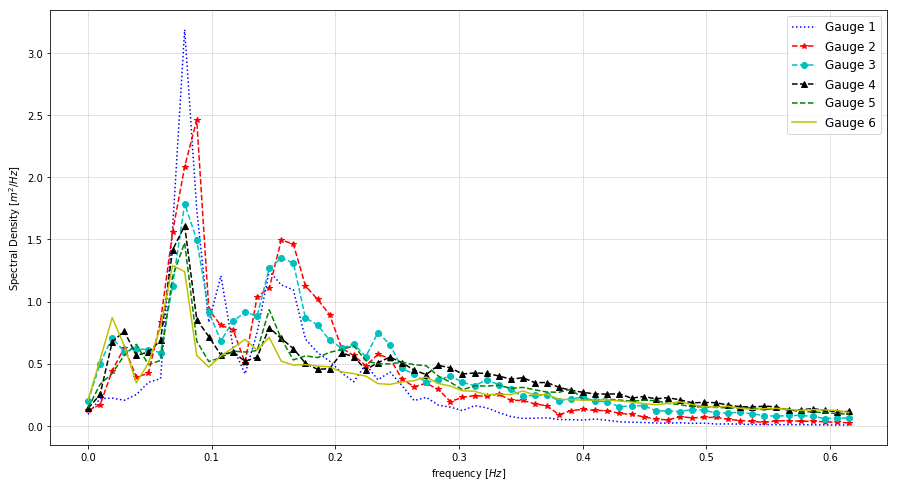

In [25]:
# pwelch
nfile = np.arange(numOfStations)
shift=np.zeros(numOfStations)
shift[:]=6000 # setting up a window of 250 instances (the smaller the window the smoother the transformed spectrum will look -- more averaging)

# line types for plotting 4 stations
lineType=['b:', 'r--*', 'c--o', 'k--^',
         'g--', 'y-']#, 'p--', 's--',
         #'b--x', 'r--^', 'c--s', 'k--*',
         #'b','r','g','k','y','m','b--*']

fig = plt.figure(figsize=(15,8))

fileName = 'Station_Hmo.txt'
out_path = os.path.join(plotDir,fileName)
fileOut = open(out_path,'w')

for i, fileIndex in enumerate(nfile):
    print("Index: ", i, "...  Station #: ", fileIndex+1)

    timeS = stationList[fileIndex][:,0] # first row in sta_000# is time stamp
    etaTS = stationList[fileIndex][:,1] # second row is time series of eta (third and fourth are U and V)
        
    eta = etaTS[int(i):]
    time = timeS[int(i):]
    
    # Frequncy of Stations Recording: in your 'input.txt' you chose to write to station file every dt=0.1 second
    dt = 0.1      
    freqS = 1.0/dt # is a sampling rate (Hz)
    
    nOverlap=512 #256 #64 #32
    nFFT=1024 #512 #128 #64
    myWindow=np.bartlett(nFFT)
        
    f, Pxx_spec_den = sig.welch(x=eta, fs=freqS, window=myWindow,
                                nperseg=nFFT,
                                noverlap=nOverlap,
                                nfft=nFFT,
                                scaling='density')

    plotRange = int(len(f)/8.)
    
    # send to calculate Hsig
    Hmo = calculateHsig(f,Pxx_spec_den, i)
    
   # write Hmo file
    fr = str("sta_%d %.4f\n"%(int(i+1), Hmo)) 
    fileOut.write(fr)
    
    if fileIndex <12:
        plt.plot(f[0:plotRange], np.sqrt(Pxx_spec_den[0:plotRange]), lineType[i])
        plt.legend(['Gauge 1','Gauge 2','Gauge 3','Gauge 4',#]
               'Gauge 5','Gauge 6']#,'Gauge 7','Gauge 8',
               #'Gauge 9','Gauge 10','Gauge 11','Gauge 12',
               #'Gauge 13','Gauge 14','Gauge 15','Gauge 16',
               #'Gauge 17','Gauge 18','Gauge 19']
                   , prop={'size':12})
    else:
        pass # plot gauges 13 and above
    
plt.xlabel('frequency $[Hz]$')
plt.ylabel('Spectral Density $[m^2/Hz]$')
plt.grid(linestyle='--', linewidth=0.5)
plt.savefig(os.path.join(plotDir,'Station-Spectra.png'), dpi=300)
fileOut.close()

$H_{mo}$ using Goda's formula
===========

In [78]:
def getHmo(Tfinal, transientInterval, 
           numOfTimeIntervals, timeInterval, entriesForTransient, 
           entriesPerInterval, stations):
    
    Hmo_Goda_Per_Station = []

    for i,station in enumerate(stationList):
        initialIndex = entriesForTransient
        finalIndex = initialIndex+entriesPerInterval
    
        eta = []
        etaMean = []
        Hmo_Goda = []
        intervalEtaSquaredTrapz = []
        
        for index in range(int(numOfTimeIntervals)):
            newEta = station[initialIndex:finalIndex,1]
            eta.append(newEta)
            etaMean.append(newEta.mean())
        
            intervalEtaSquaredTrapz.append(np.trapz((eta[index]-etaMean[index])**2, dx=dt))  
            Hmo_Goda.append(4.004 * np.sqrt(1/timeInterval * intervalEtaSquaredTrapz[index])) # dt was already used above dx=0.1
                
            # update indices for next interval
            initialIndex = finalIndex
            finalIndex = initialIndex+entriesPerInterval
        
        #Hmo_Goda_Per_Station.append(Hmo_Goda)
        outputString = 'Station: {}:   ==>    Hmo_Goda (meters) = [{}, {}, {}]'.format(str(i+1),
                                                                                       str(Hmo_Goda[0]),
                                                                                       str(Hmo_Goda[1]),
                                                                                       str(Hmo_Goda[2]))#,
                                                                                    #str(Hmo_Goda[3]))
                      
        print(outputString)

    #fout.close()

In [36]:
dt = 0.1
Tfinal=3600.0 #7200.0


 # ^^^^^ change Tfinal!!!!!
    
    
    
numOfEntries = int(Tfinal/dt)+1

# setup time frames for Hmo analysis (as we have visible wave setup - MWL change)
transientInterval = 600.0 #in seconds
numOfTimeIntervals = 3
timeInterval = (Tfinal-transientInterval)/numOfTimeIntervals
entriesPerInterval = int(timeInterval/dt)
entriesForTransient = int(transientInterval/dt)+1
    
getHmo(Tfinal, transientInterval, 
       numOfTimeIntervals, timeInterval, entriesForTransient, 
       entriesPerInterval, stationList)

Station: 1:   ==>    Hmo_Goda (meters) = [2.8590747753369694, 2.89559760535278, 2.853054786244633]
Station: 2:   ==>    Hmo_Goda (meters) = [2.7783097508185164, 2.7435187556933194, 2.777768741922762]
Station: 3:   ==>    Hmo_Goda (meters) = [2.41639181135986, 2.4475947099647333, 2.4081106581710894]
Station: 4:   ==>    Hmo_Goda (meters) = [1.787060832269785, 1.7986530306892297, 1.7852665040779523]
Station: 5:   ==>    Hmo_Goda (meters) = [1.683738026741975, 1.684221247185631, 1.6835550760446103]
Station: 6:   ==>    Hmo_Goda (meters) = [1.6595538969320827, 1.692230213881496, 1.6568806765448572]
